In [2]:
from utils.utils import *

In [3]:
DIR='./DATA/IASI/EXTERNAL/SUSTAINABLE/DUFOUR/IASIO3daily_PolEASIA/H2O/'
DIR_TEST = '/Images/'

In [4]:
deg = .125
size1 = .0625

## LOOP
start = 1
end = 20

# Dates
day = 4
image_type="LT"
year=2008
month=5

## THRESH
global_regions = []
global_contours = []
global_mser = []
global_laplacian = []
global_thresh = 40
global_trhesh_step = 3
global_thresh_down = global_thresh - global_trhesh_step
global_thresh_condition = False

2008 5 31
4
./DATA/IASI/EXTERNAL/SUSTAINABLE/DUFOUR/IASIO3daily_PolEASIA/H2O/IASIdaily_20080504.nc
end read nc
/home/camillo/Documents/Stage/ozone-pollution/utils/utils.py:100: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # ,cmap=plt.cm.Greys)
Daily_IASI_gridded_raw.20080504.png
end month


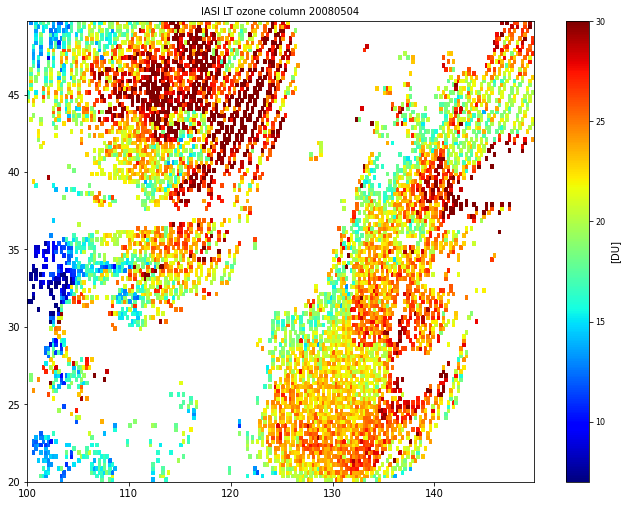

In [7]:
### REFERENCE
plot_original_data(DIR,year,month,day,image_type,False)

end read nc


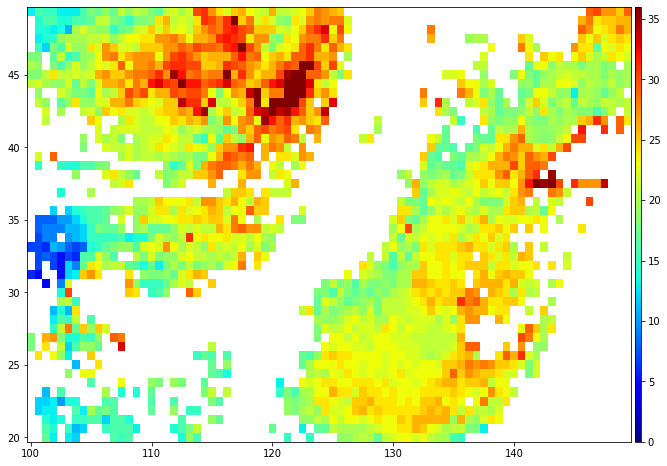

In [10]:
degree = 0.625 # deg * i
size = 0.3125 # (degree * size1) /  deg
image_name = DIR_TEST + image_type+"-mesh-"+str(year)+"%02d"%month+"%02d"%day+".png"

lat_g = np.arange(20.,50.,degree)
lon_g = np.arange(100.,150.,degree)

#initialization
colgrid = np.zeros([lat_g.shape[0],lon_g.shape[0]], np.uint8)

for year in range(2008,2009):
  for month in range(5,6):
    for dd in range (day,day+1):
      
      fname = DIR + 'IASIdaily_' + str(year) + "%02d"%month + "%02d"%dd + '.nc'

      #read IASI data in nc archive
      if not(os.path.isfile(fname)):
        continue

      nc = netCDF4.Dataset(fname)

      flg = nc.variables['flag'][:]
      mask1 = (flg == 0)
      
      lat = nc.variables['lat'][mask1]
      lon = nc.variables['lon'][mask1]
      col = nc.variables[image_type][mask1]
      nc.close()

      print('end read nc')
      mask2 = (np.isnan(col) == False) 

      # gridding the data
      for ilat in range(lat_g.shape[0]):
        for ilon in range(lon_g.shape[0]):
          # Grille régulier
          # 25 km
          # 0 25 degrée lattitude et longitude

          # Grille regulier of 0.125 degree
          maskgrid = (lat[:] >= (lat_g[ilat] - size)) & (lat[:] < (lat_g[ilat] + size)) & (lon[:] >= (lon_g[ilon] - size)) & (lon[:] < (lon_g[ilon] + size))
          
          # Defining invalid data
          mask = mask2 & maskgrid

          if len(col[mask]) != 0:
            median = np.mean(col[mask])
            colgrid[ilat,ilon] = median

      # We mark the values at colgrid as invalid because they are maybe false positives or bad sampling
      colgrid1 = ma.masked_values(colgrid, 0.)
      v_x, v_y = np.meshgrid(lon_g, lat_g)

      #Plot the original
      fig1, (f1ax1) = plt.subplots(1, 1, figsize = (11,8))
      divider = make_axes_locatable(f1ax1)
      cax = divider.append_axes('right', size='1%', pad=0.05)
      colorinfo = f1ax1.pcolormesh(v_x, v_y, colgrid1, shading='nearest',cmap='jet', vmin=colgrid.min(), vmax=36)
      fig1.colorbar(colorinfo, cax=cax)

In [ ]:
x = [pnt[0] for pnt in colgrid[:]]
y = [pnt[1] for pnt in colgrid[:]]
print(x)
print(y)

xrange = [0, colgrid.shape[1]]
yrange = [0, colgrid.shape[0]]

kde = sns.kdeplot(x,y, color='r', shade=True, Label='Pollution',
            cmap="Reds", shade_lowest=True)

kde.invert_yaxis()


In [ ]:
mser_init = cv2.MSER_create()
mser_init.setMaxArea(1000)

#image_mser_init = cv2.cvtColor(image_mser, cv2.COLOR_GRAY2RGB)

regions0, bboxes0 = mser_init.detectRegions(colgrid1)
#regions = sorted(regions, key=cv2.contourArea, reverse=True)

#black_image = np.zeros(colgrid.shape, np.uint8)

test = colgrid1.copy()

for p in regions0:
  for k in p:
    cv2.circle(test, (k[0],k[1]), radius=0, color=(255, 0, 0), thickness=-1)

#image_mser = cv2.bitwise_and(image_mser,image_mser,mask = image_holes_dilate_inv )
print(len(regions0))

fig, (ax0) = plt.subplots(1,1, figsize=(11,8))
ax0.imshow(test)
ax0.invert_yaxis()


In [ ]:
temp_image = colgrid1.copy()

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
fig3 = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

for j,r in enumerate(regions0):
  region = list()
  hull = cv2.convexHull(r)

  for h in hull:
      region.append(h[0].tolist())

  region.append(region[0])
  poly = Polygon(region)

  line = LineString(region)
  x, y = line.xy

  coord_x = int(line.centroid.x)
  coord_y = int(line.centroid.y)

  value_pixel = temp_image[coord_y, coord_x]
  z = np.full(len(x),value_pixel)

  xs = [pnt[0] for pnt in r[:]]
  ys = [pnt[1] for pnt in r[:]]
  zs = np.full(len(xs),value_pixel)  #    [temp_image[pnt[1],pnt[0]] if temp_image[pnt[1],pnt[0]] > 0 else np.nan for pnt in r[:]]

  xrange = [0, colgrid1.shape[1]]
  yrange = [0, colgrid1.shape[0]]
  zrange = [0, colgrid.max()]

  ax0.scatter(xs,ys, marker='.', label='Region ' + str(j))
  ax0.set_xlim(*xrange)
  ax0.set_ylim(*yrange)
  ax0.set_title('Region ')
  ax0.legend()

  ax1.plot(x, y, label='Region ' + str(j))
  ax1.set_xlim(*xrange)
  ax1.set_ylim(*yrange)
  ax1.set_title('ConvexHull ')
  ax1.legend()

  #gs = GeoSeries(Point(pnt[0],pnt[1]) for pnt in r)
  #ax.set_title('Region ' + str(i) + ' - subregion ' + str(j))
  #ax = gs.plot(marker='.', color='red', markersize=1)
  #ax.set_xlim(*xrange)
  #ax.set_ylim(*yrange)

  ax.scatter(xs,ys,zs, marker='.')
  ax.set_zlim(*zrange)

In [ ]:
perspective = colgrid.copy()

R = np.where(perspective != 0, perspective, np.nan)

# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:perspective.shape[0], 0:perspective.shape[1]]

fig = plt.figure(figsize = (11,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, R, rstride=1, linewidth=0, edgecolor ='none')
fig.show()

In [ ]:

gradx, grady = np.gradient(colgrid, edge_order=1)

### TO OPENCV

data = np.full((colgrid.shape[0], colgrid.shape[1]), colgrid, np.uint8)
img_bgr = cv2.cvtColor(data, cv2.COLOR_GRAY2BGR)
img_rgb = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

### SCALE
scale_percent = 200 #200 # percent of original size
width = int(gray.shape[1] * scale_percent / 100)
height = int(gray.shape[0] * scale_percent / 100)
dim = (width, height)
gray = cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)
gray = cv2.normalize(gray, np.ones((lon_g.shape[0], lat_g.shape[0])) , 0, 255, cv2.NORM_MINMAX )

### MORPHO FILTERS
kernel = np.ones((3,3),np.uint8)
closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations = 2)
image_close = closing.copy()

## REMOVING THE HOLES
image_large_close = cv2.morphologyEx(closing, cv2.MORPH_CLOSE, np.ones((9,9),np.uint8), iterations = 2)
image_holes = image_close.copy()
# Take the holes (pixels value = 0) and set it as 255
image_holes = np.where(image_holes == 0, 255, image_holes) 
image_holes = np.where(image_holes != 255, 0, image_holes) # This is the mask of the background
image_holes_dilate = cv2.morphologyEx(image_holes, cv2.MORPH_DILATE, np.ones((3,3),np.uint8), iterations = 1)
image_holes_dilate_inv = cv2.bitwise_not(image_holes_dilate) # This is the mask of the foreground 

gray = image_close.copy()

## Below code convert image gradient in both x and y direction
image_laplacian = cv2.Laplacian(gray, cv2.CV_16U, ksize=3) 
image_laplacian = np.uint8(np.absolute(image_laplacian))
image_laplacian = cv2.bitwise_and(image_laplacian,image_laplacian,mask = image_holes_dilate_inv)

## Below code convert image gradient in x direction
sobelx= cv2.Sobel(gray, 0, dx=1,dy=0)
sobelx= np.uint8(np.absolute(sobelx))
## Below code convert image gradient in y direction
sobely= cv2.Sobel(gray, 0, dx=0,dy=1)
sobely = np.uint8(np.absolute(sobely))

image_contour = image_laplacian.copy()
edge = cv2.Canny(image_contour, colgrid.min(), colgrid.max())

contours, h = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

for c in contours:
  hull = cv2.convexHull(c)
  cv2.drawContours(image_contour, [hull], 0, (255,255, 255), 1)

#Create MSER object
mser = cv2.MSER_create()
mser.setMaxArea(8000)

image_mser = gray.copy()
image_mser = cv2.cvtColor(image_mser, cv2.COLOR_GRAY2RGB)

regions, bboxes = mser.detectRegions(image_mser)
regions = sorted(regions, key=cv2.contourArea, reverse=True)

black_image = np.zeros(gray.shape, np.uint8)

for p in regions:
  for k in p:
    cv2.circle(image_mser, (k[0],k[1]), radius=0, color=(255, 0, 0), thickness=-1)

image_mser = cv2.bitwise_and(image_mser,image_mser,mask = image_holes_dilate_inv )

_, labels, _, _ = cv2.connectedComponentsWithStats(image_laplacian, connectivity=8, ltype=cv2.CV_32S) 

# Map component labels to hue val
label_hue = np.uint8(170 * labels/np.max(labels))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

# cvt to BGR for display
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

# set bg label to black
labeled_img[label_hue==0] = 0

global_initial_gray = gray.copy()

fig, (ax0,ax1,ax2,ax3) = plt.subplots(1,4, figsize=(31,20))
ax0.imshow(gray, cmap="gray")
ax0.invert_yaxis()
ax1.imshow(image_laplacian, cmap="gray")
ax1.invert_yaxis()
ax2.imshow(image_mser)
ax2.invert_yaxis()
ax3.imshow(image_holes_dilate_inv, cmap="gray")
ax3.invert_yaxis()

In [ ]:
test_gray_1 = img_rgb.copy()
test_gray_1 = cv2.cvtColor(test_gray_1, cv2.COLOR_RGB2GRAY)
print(test_gray_1.shape)
#test_gray_1 = cv2.normalize(test_gray_1, np.ones(test_gray_1.shape , 0, 255, cv2.NORM_MINMAX ))
test_gray_1 = cv2.normalize(test_gray_1, np.ones((test_gray_1.shape[0], test_gray_1.shape[1])) , 0, 255, cv2.NORM_MINMAX )

fig1, (f1ax1) = plt.subplots(1, 1, figsize = (11,8))
divider = make_axes_locatable(f1ax1)
cax = divider.append_axes('right', size='2%', pad=0.05)
colorinfo = f1ax1.imshow(test_gray_1, cmap="gray")
f1ax1.invert_yaxis()
fig1.colorbar(colorinfo, cax=cax)

In [ ]:
perspective = gray.copy()

R = np.where(perspective != 0, perspective, np.nan)

# create the x and y coordinate arrays (here we just use pixel indices)
xx, yy = np.mgrid[0:perspective.shape[0], 0:perspective.shape[1]]

fig = plt.figure(figsize = (11,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, R, rstride=1, linewidth=0)
fig.show()

In [ ]:
test_gray_2 = gray.copy()
test_gray_2 = cv2.normalize(test_gray_2, np.ones((test_gray_2.shape[0], test_gray_2.shape[1])) , 0, 255, cv2.NORM_MINMAX )

fig1, (f1ax1) = plt.subplots(1, 1, figsize = (11,8))
divider = make_axes_locatable(f1ax1)
cax = divider.append_axes('right', size='2%', pad=0.05)
colorinfo = f1ax1.imshow(test_gray_2, cmap="gray")
f1ax1.invert_yaxis()
fig1.colorbar(colorinfo, cax=cax)

In [ ]:

isClosed = True
## Blue color in BGR 
color = (255, 0, 0)
## Line thickness of 2 px 
thickness = -1

#fig2, ax0 = plt.subplots(1,1)
f3d = plt.figure(figsize=(11,8))
ax3d = plt.axes(projection='3d')

for c in regions:
  region = list()
  temp = np.zeros(black_image.shape, np.uint8)
  hull = cv2.convexHull(c)
  
  for h in hull:
    region.append(h[0].tolist())

  region.append(region[0])
  poly = Polygon(region)

  xrange = [0, black_image.shape[1]]
  yrange = [0, black_image.shape[0]]

  gs = GeoSeries(Point(pnt[0],pnt[1]) for pnt in c)
  ax0 = gs.plot(marker='.', color='red', markersize=1)
  ax0.set_xlim(*xrange)
  ax0.set_ylim(*yrange)

  line = LineString(poly.exterior)
  x, y = line.xy

  coord_x = int(line.centroid.x)
  coord_y = int(line.centroid.y)

  value_pixel = gray[coord_y, coord_x]

  x_ = [pnt[0] for pnt in c]
  y_ = [pnt[1] for pnt in c]
  z_ = np.full(len(x_),value_pixel)

  z = np.full(len(x),value_pixel)
  # Data for a three-dimensional line
  #ax3d.plot3D(x, y, z, label="Gray value: " +str(value_pixel) )
  ax3d.scatter(x_, y_, z_)
  #leg = ax3d.legend()

In [ ]:
temp_image = gray.copy()

background_image = global_initial_gray.copy()
background_image = np.where(background_image == 0, 255, background_image)
background_image = np.where(background_image != 255, 0, background_image)

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
fig3 = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

for j,r in enumerate(regions):
  region = list()
  hull = cv2.convexHull(r)

  for h in hull:
      region.append(h[0].tolist())

  region.append(region[0])
  poly = Polygon(region)

  line = LineString(region)
  x, y = line.xy

  coord_x = int(line.centroid.x)
  coord_y = int(line.centroid.y)

  value_pixel = temp_image[coord_y, coord_x]
  z = np.full(len(x),value_pixel)

  xs = [pnt[0] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
  ys = [pnt[1] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
  zs = np.full(len(xs),value_pixel)  #    [temp_image[pnt[1],pnt[0]] if temp_image[pnt[1],pnt[0]] > 0 else np.nan for pnt in r[:]]

  xrange = [0, gray.shape[1]]
  yrange = [0, gray.shape[0]]
  zrange = [0, colgrid.max()]

  ax0.scatter(xs,ys, marker='.', label='Region ' + str(j))
  ax0.set_xlim(*xrange)
  ax0.set_ylim(*yrange)
  ax0.set_title('Region ')
  ax0.legend()

  ax1.plot(x, y, label='Region ' + str(j))
  ax1.set_xlim(*xrange)
  ax1.set_ylim(*yrange)
  ax1.set_title('ConvexHull ')
  ax1.legend()

  #gs = GeoSeries(Point(pnt[0],pnt[1]) for pnt in r)
  #ax.set_title('Region ' + str(i) + ' - subregion ' + str(j))
  #ax = gs.plot(marker='.', color='red', markersize=1)
  #ax.set_xlim(*xrange)
  #ax.set_ylim(*yrange)

  ax.scatter(xs,ys,zs, marker='.')
  ax.set_zlim(*zrange)
  

In [ ]:

temp_g_t = global_thresh
temp_g_t_d = global_thresh_down
temp_condit = global_thresh_condition
temp_g_step = global_trhesh_step

for i in range(start,end):
  if (i==0):
    continue

  print("Threshold", temp_g_t)
  if temp_g_t < 0:
    break

  degree = 0.625 # deg * i
  size = 0.3125 # (degree * size1) /  deg
  thres=(i-20)
  iteration=i
  image_name = DIR_TEST + image_type+"-mesh-"+str(year)+"%02d"%month+"%02d"%day+"-i-0"+str(i)+".png"
  # plot_sequence_images(degree = deg2, size = size2, thres=(i-20), iteration=i, image_type=image_type, day=day )

  lat_g = np.arange(20.,50.,degree)
  lon_g = np.arange(100.,150.,degree)

  #initialization
  colgrid = np.zeros([lat_g.shape[0],lon_g.shape[0]], np.uint8)

  for year in range(2008,2009):
    for month in range(5,6):
      ndays = calendar.mdays[month] + (month==2 and calendar.isleap(year))
      print(year,month,ndays)

      for dd in range (day,day+1):
        
        fname = DIR+'IASIdaily_'+str(year)+"%02d"%month+"%02d"%dd+'.nc'

        #read IASI data in nc archive
        if not(os.path.isfile(fname)):
          continue

        nc = netCDF4.Dataset(fname)
        flg = nc.variables['flag'][:]
        mask1 = (flg == 0)
        
        lat = nc.variables['lat'][mask1]
        lon = nc.variables['lon'][mask1]
        col = nc.variables[image_type][mask1]
        nc.close()

        print("Col",int(col.max() - 5))
        if temp_g_t < int(col.max() - 5) and temp_condit == False:
          temp_g_t = int(col.max() - 10)
          temp_g_step = 5
          temp_condit = True
      
        print('end read nc')
        mask2 = (np.isnan(col) == False) 

        # gridding the data
        for ilat in range(lat_g.shape[0]):
          for ilon in range(lon_g.shape[0]):
            # Grille régulier
            # 25 km
            # 0 25 degrée lattitude et longitude

            # Grille regulier of 0.125 degree
            maskgrid = (lat[:] >= (lat_g[ilat] - size)) & (lat[:] < (lat_g[ilat] + size)) & (lon[:] >= (lon_g[ilon] - size)) & (lon[:] < (lon_g[ilon] + size))
            
            # Defining invalid data
            mask = mask2 & maskgrid

            # Add a media filter for the grill regulier
            isMask = (len(col[mask]) != 0) & (col[mask] >= thres).all()

            if len(col[mask]) != 0:
              median = np.mean(col[mask])
              if median >= temp_g_t:
                colgrid[ilat,ilon] = median

        # We mark the values at colgrid as invalid because they are maybe false positives or bad sampling
        #colgrid = ma.masked_values(colgrid, 0.)

        v_x, v_y = np.meshgrid(lon_g, lat_g)
        gradx, grady = np.gradient(colgrid, edge_order=1)

        data = np.full((colgrid.shape[0], colgrid.shape[1]), colgrid, np.uint8)
        img_bgr = cv2.cvtColor(data, cv2.COLOR_GRAY2BGR)
        img_rgb = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
        #gray = cv2.normalize(gray, np.ones((lon_g.shape[0], lat_g.shape[0])) , 0, 255, cv2.NORM_MINMAX )

        scale_percent = 200 #200 # percent of original size
        width = int(gray.shape[1] * scale_percent / 100)
        height = int(gray.shape[0] * scale_percent / 100)
        dim = (width, height)
        gray = cv2.resize(gray, dim, interpolation = cv2.INTER_AREA)

        kernel = np.ones((3,3),np.uint8)
        closing = cv2.morphologyEx(gray, cv2.MORPH_CLOSE, kernel, iterations = 2)
        image_close = closing.copy()

        image_large_close = cv2.morphologyEx(closing, cv2.MORPH_CLOSE, np.ones((9,9),np.uint8), iterations = 2)
        image_holes = image_close.copy()

        # DILATE HOLES
        image_holes = np.where(image_holes == 0, 255, image_holes)
        image_holes = np.where(image_holes != 255, 0, image_holes)
        image_holes_dilate = cv2.morphologyEx(image_holes, cv2.MORPH_DILATE, np.ones((3,3),np.uint8), iterations = 2)
        image_holes_dilate_inv = cv2.bitwise_not(image_holes_dilate)
        
        gray = image_close.copy()
        global_regions.append(gray)

        ## Below code convert image gradient in both x and y direction
        image_laplacian = cv2.Laplacian(gray, cv2.CV_16U, ksize=3) 
        image_laplacian = np.uint8(np.absolute(image_laplacian))
        image_laplacian = cv2.bitwise_and(image_laplacian,image_laplacian,mask = image_holes_dilate_inv)

        global_laplacian.append(image_laplacian)
        ## Below code convert image gradient in x direction
        sobelx= cv2.Sobel(gray, 0, dx=1,dy=0)
        sobelx= np.uint8(np.absolute(sobelx))
        ## Below code convert image gradient in y direction
        sobely= cv2.Sobel(gray, 0, dx=0,dy=1)
        sobely = np.uint8(np.absolute(sobely))
        
        #Create MSER object
        mser = cv2.MSER_create()
        mser.setMaxArea(8000)
        image_mser = gray.copy()

        #detect regions in gray scale image
        image_mser = cv2.cvtColor(image_mser, cv2.COLOR_GRAY2RGB)
        regions, bboxes = mser.detectRegions(image_mser)
        regions = sorted(regions, key=cv2.contourArea, reverse=True)

        for p in regions:
          for k in p:
            cv2.circle(image_mser, (k[0],k[1]), radius=0, color=(255, 0, 0), thickness=-1)

        #background_image = global_initial_gray.copy()
        #background_image = np.where(background_image == 0, 255, background_image)
        #background_image = np.where(background_image != 255, 0, background_image)
        #background_image = cv2.cvtColor(background_image, cv2.COLOR_GRAY2RGB)
        #regions_background, bboxes_background = mser.detectRegions(background_image)
        #regions_background = sorted(regions_background, key=cv2.contourArea, reverse=True)

        global_mser.append(regions)
        global_contours.append(bboxes)

        image_mser = cv2.bitwise_and(image_mser,image_mser,mask = image_holes_dilate_inv)

        _, labels, _, _ = cv2.connectedComponentsWithStats(image_laplacian, connectivity=8, ltype=cv2.CV_32S) 

        # Map component labels to hue val
        label_hue = np.uint8(170 * labels/np.max(labels))
        blank_ch = 255*np.ones_like(label_hue)
        labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

        # cvt to BGR for display
        labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

        # set bg label to black
        labeled_img[label_hue==0] = 0

        fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(21,15))
        ax0.imshow(gray, cmap="gray")
        ax0.invert_yaxis()
        ax1.imshow(image_laplacian, cmap="gray")
        ax1.invert_yaxis()
        ax2.imshow(image_mser)
        ax2.invert_yaxis()

  temp_g_t -= temp_g_step
  temp_g_t_d -= temp_g_step
  print('end month')

In [ ]:
mix_regions = global_mser.copy()
mix_boxes = global_contours.copy()
temp_image = gray.copy()

background_image = global_initial_gray.copy()
background_image = np.where(background_image == 0, 255, background_image)
background_image = np.where(background_image != 255, 0, background_image)

if image_type == "UT":
  starting_point = 4
else:
  starting_point = 3

for i, level_regions in enumerate(mix_regions[1:]):
  if len(mix_regions) == 0:
    print("Not data for region ", i)
    break

  #hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in level_regions]
  #for ii, cnt in enumerate(hulls):
  #  for jj, cnt in enumerate(hulls):
  #    if ii >= jj:
  #      continue
  #    
  #    if len(mix_boxes[i]) == 0:
  #      continue
  #      
  #    box_i = mix_boxes[i][ii]
  #    box_j = mix_boxes[i][jj]
  #
  #    tl_i = box_i[:2]
  #    tl_j = box_j[:2]
  #
  #    br_i = tl_i + box_i[2:]
  #    br_j = tl_j + box_j[2:]
  #
  #    tl = np.maximum(tl_i, tl_j)
  #    br = np.minimum(br_i, br_j)
  #    intersected_rect = br - tl

  #    intersection = np.prod(intersected_rect) if intersected_rect[0] > 0 and intersected_rect[1] > 0 else 0
  #    union = np.prod(box_i[2:]) + np.prod(box_j[2:]) - intersection
  #    iou = intersection / union

  #    #if (iou > 0.5):
  #    #  print("HIs",iou, "id", i, "subreg", ii, "subsub", jj)
  #    #  #del level_regions[i]

  fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
  fig3 = plt.figure(figsize =(14, 9))
  ax = plt.axes(projection ='3d')

  for j,r in enumerate(level_regions):
    region = list()
    hull = cv2.convexHull(r)

    for h in hull:
        region.append(h[0].tolist())

    region.append(region[0])
    poly = Polygon(region)

    line = LineString(region)
    x, y = line.xy

    coord_x = int(line.centroid.x)
    coord_y = int(line.centroid.y)

    value_pixel = temp_image[coord_y, coord_x]
    z = np.full(len(x),value_pixel)

    xs = [pnt[0] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
    ys = [pnt[1] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
    zs = np.full(len(xs),value_pixel) #  [temp_image[pnt[1],pnt[0]] if temp_image[pnt[1],pnt[0]] > 0 else np.nan for pnt in r[:]]

    xrange = [0, gray.shape[1]]
    yrange = [0, gray.shape[0]]
    zrange = [0, colgrid.max()]

    ax0.scatter(xs,ys, marker='.', label='Region ' + str(j))
    ax0.set_xlim(*xrange)
    ax0.set_ylim(*yrange)
    ax0.set_title('Region ' + str(i))
    #ax0.legend()

    ax1.plot(x, y, label='Region ' + str(j))
    ax1.set_xlim(*xrange)
    ax1.set_ylim(*yrange)
    ax1.set_title('ConvexHull ' + str(i))
    #ax1.legend()

    #gs = GeoSeries(Point(pnt[0],pnt[1]) for pnt in r)
    #ax.set_title('Region ' + str(i) + ' - subregion ' + str(j))
    #ax = gs.plot(marker='.', color='red', markersize=1)
    #ax.set_xlim(*xrange)
    #ax.set_ylim(*yrange)

    ax.scatter(xs,ys,zs, marker='.')
    ax.set_zlim(*zrange)
    

In [ ]:
#fig2, ax0 = plt.subplots(1,1)
f3d = plt.figure(figsize=(11,8))
ax3d = plt.axes(projection='3d')

for i, level_regions in enumerate(mix_regions):
    print("Region " + str(i) + " of " + str(len(mix_regions))+ " started.")
    for r in level_regions:
        region = list()
        temp = np.zeros(black_image.shape, np.uint8)
        hull = cv2.convexHull(r)
  
        for h in hull:
            region.append(h[0].tolist())

        region.append(region[0])
        poly = Polygon(region)

        xrange = [0, black_image.shape[1]]
        yrange = [0, black_image.shape[0]]

        line = LineString(poly.exterior)
        x, y = line.xy

        coord_x = int(line.centroid.x)
        coord_y = int(line.centroid.y)

        value_pixel = gray[coord_y, coord_x]

        x_ = [pnt[0] for pnt in r]
        y_ = [pnt[1] for pnt in r]
        z_ = np.full(len(x_),value_pixel)

        z = np.full(len(x),value_pixel)
        # Data for a three-dimensional line
        ax3d.plot3D(x, y, z, label="Gray value: " +str(value_pixel) )
        #ax3d.scatter(x_, y_, z_)
        #leg = ax3d.legend()
    print("Region " + str(i) + " done.")
print("Done :)")

In [ ]:
## CALCULATE THE BACKGROUND AT EACH LEVEL AND THE FINAL GRAY IMAGE

test_global_regs = global_regions.copy()



i = 0
for image in range(len(test_global_regs) - 1):
  f, (ax1) = plt.subplots(1, 1, figsize = (11,8))

  if i == 0:
    image1 = test_global_regs[i]
  else:
    image1 = image3
  image2 = test_global_regs[i + 1]
  image3 = cv2.addWeighted(image1,1,image2,.7,0)

  combination_regions = image3.copy()
  current_region = test_global_regs[i]

  background_image = current_region.copy()
  background_image = np.where(background_image == 0, 255, background_image)
  background_image = np.where(background_image != 255, 0, background_image)

  
  ax1.imshow(combination_regions, cmap="gray")
  ax1.invert_yaxis()

  # f.savefig(DIR_TEST + "/05-03/" + image_type + "/" + image_type + "_combination_" + str(year) + "-" + str(month) + "-" + str(day) + "_deg_" + str(degree) + "_i_0" + str(i) + ".png", pad_inches=.01)

  i += 1

In [ ]:
mser1 = cv2.MSER_create()
image_background = background_image.copy() # background
image_pollution = combination_regions.copy() # foreground
mser1.setMaxArea(8000)

image_pollution = cv2.cvtColor(image_pollution, cv2.COLOR_GRAY2RGB)
regions_pollution, bboxes4 = mser1.detectRegions(image_pollution)
regions_pollution = sorted(regions_pollution, key=cv2.contourArea, reverse=True)

temp = np.zeros(image_pollution.shape, np.uint8)

for p in regions_pollution:
  for k in p:
    cv2.circle(image_pollution, (k[0],k[1]), radius=0, color=(255, 0, 0), thickness=-1)


image_pollution = cv2.bitwise_and(image_pollution,image_pollution,mask = image_holes_dilate_inv)

f, (ax0) = plt.subplots(1,1, figsize=(11,8))
ax0.imshow(image_pollution)
ax0.invert_yaxis()
#ax1.imshow(combination_regions, cmap="gray")
#ax1.invert_yaxis()

In [ ]:
temp_image = combination_regions.copy()

background_image = global_initial_gray.copy()
background_image = np.where(background_image == 0, 255, background_image)
background_image = np.where(background_image != 255, 0, background_image)

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,5))
fig3 = plt.figure(figsize =(14, 9))
ax = plt.axes(projection ='3d')

for j,r in enumerate(regions_pollution):
  region = list()
  hull = cv2.convexHull(r)

  for h in hull:
      region.append(h[0].tolist())

  region.append(region[0])
  poly = Polygon(region)

  line = LineString(region)
  x, y = line.xy

  coord_x = int(line.centroid.x)
  coord_y = int(line.centroid.y)

  value_pixel = temp_image[coord_y, coord_x]
  z = np.full(len(x),value_pixel)

  xs = [pnt[0] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
  ys = [pnt[1] if background_image[pnt[1],pnt[0]] != 255 else 0 for pnt in r[:]]
  zs =  np.full(len(xs),value_pixel) #    [temp_image[pnt[1],pnt[0]] if temp_image[pnt[1],pnt[0]] > 0 else np.nan for pnt in r[:]]

  xrange = [0, gray.shape[1]]
  yrange = [0, gray.shape[0]]
  zrange = [0, 255]

  ax0.scatter(xs,ys, marker='.', label='Region ' + str(j))
  ax0.set_xlim(*xrange)
  ax0.set_ylim(*yrange)
  ax0.set_title('Region ')
  #ax0.legend()

  ax1.plot(x, y, label='Region ' + str(j))
  ax1.set_xlim(*xrange)
  ax1.set_ylim(*yrange)
  ax1.set_title('ConvexHull ')
  #ax1.legend()

  #gs = GeoSeries(Point(pnt[0],pnt[1]) for pnt in r)
  #ax.set_title('Region ' + str(i) + ' - subregion ' + str(j))
  #ax = gs.plot(marker='.', color='red', markersize=1)
  #ax.set_xlim(*xrange)
  #ax.set_ylim(*yrange)

  ax.scatter(xs,ys,zs, marker='.')
  ax.set_zlim(*zrange)
  

In [ ]:
fig = plt.figure()
f3d = plt.figure(figsize=(11,8))
ax3d = plt.axes(projection='3d')

for c in regions:
  region = list()
  temp = np.zeros(combination_regions.shape, np.uint8)
  hull = cv2.convexHull(c)
  
  for h in hull:
    region.append(h[0].tolist())

  region.append(region[0])
  poly = Polygon(region)

  line = LineString(region)
  x, y = line.xy

  coord_x = int(line.centroid.x)
  coord_y = int(line.centroid.y)

  ax = fig.add_subplot(111)
  ring_patch = PolygonPatch(poly)
  ax.add_patch(ring_patch)
  xrange = [0, combination_regions.shape[1]]
  yrange = [0, combination_regions.shape[0]]
  ax.set_xlim(*xrange)
  ax.set_ylim(*yrange)

  value_pixel = combination_regions[coord_y, coord_x]
  z = np.full(len(x),value_pixel)

  # Data for a three-dimensional line
  ax3d.plot3D(x, y, z, label="Gray value: " +str(value_pixel) )
  leg = ax3d.legend()

In [ ]:
img = combination_regions.copy()
iou_th = 0.95

m_a_t = int(0.1 * np.pi * (img.shape[0] /2)**2)

print(m_a_t)

mser = cv2.MSER_create(_delta=10, _min_area=100, _max_area=10000, _max_variation=0.1)
regions, bboxes = mser.detectRegions(img)
hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in regions]

# Debug plot
img_ = img.copy()
cv2.polylines(img_, hulls, 1, (255, 0, 0), thickness=1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img_)
ax.set_title('MSER with overlapping regions')

size_dict = {k: len(region) for k, region in enumerate(regions)}

# Cull overlapping blobs
graph = nx.Graph()
graph.add_nodes_from(range(len(hulls)))

for i, cnt in enumerate(hulls):
    for j, cnt in enumerate(hulls):
        if i >= j:
            continue
        box_i = bboxes[i]
        box_j = bboxes[j]
        tl_i = box_i[:2]
        tl_j = box_j[:2]

        br_i = tl_i + box_i[2:]
        br_j = tl_j + box_j[2:]

        tl = np.maximum(tl_i, tl_j)
        br = np.minimum(br_i, br_j)
        intersected_rect = br - tl
        intersection = np.prod(intersected_rect) if intersected_rect[0] > 0 and intersected_rect[1] > 0 else 0
        union = np.prod(box_i[2:]) + np.prod(box_j[2:]) - intersection
        iou = intersection / union

        if iou > iou_th:
            graph.add_edge(i, j, iou=iou)

# make list of unique regions - pick the smallest region
#trees = list(nx.connected_components(graph))
trees = (graph.subgraph(c) for c in nx.connected_components(graph))

unique_blobs = []
for tree in trees:
    # Choose the smallest region
    smallest_idx = None
    smallest_blob = np.inf
    for node in tree.nodes():
        if size_dict[node] < smallest_blob:
            smallest_blob = size_dict[node]
            smallest_idx = node

        unique_blobs.append(smallest_idx)
unique_blobs = unique_blobs
hulls = [hulls[k] for k in unique_blobs]
regions = [regions[k] for k in unique_blobs]
bboxes = [bboxes[k] for k in unique_blobs]
size_dict = {k: len(region) for k, region in enumerate(regions)}

# debug plot
img_ = img.copy()
cv2.polylines(img_, hulls, 1, (255, 0, 0), thickness=1)
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img_)
ax.set_title('MSER with unique regions')
